In [ ]:
!pip3 uninstall keras
!pip3 install keras==2.2.4

In [ ]:
!pip3 uninstall tensorflow
!pip3 install tensorflow-gpu==1.14

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import cv2
from sklearn.model_selection import train_test_split
import pickle
import os
import pandas as pd
import random
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau


In [ ]:
!cp '/content/drive/My Drive/GG SSD/train_0506.zip' /content/

In [ ]:
!unzip train_0506.zip

In [ ]:
################# Parameters #####################
path = "Train" # folder with all the class folders
imageDimesions = (32,32,3)
testRatio = 0.2    # if 1000 images split will 200 for testing
validationRatio = 0.2 # if 1000 images 20% of remaining 800 will be 160 for validation
##############################################c
#####

In [ ]:
!rm '/content/Train/.DS_Store'

In [ ]:
############################### Importing of the Images
count = 0
images = []
classNo = []
myList = os.listdir(path)
print(myList)
print("Total Classes Detected:",len(myList))
noOfClasses=len(myList)
print("Importing Classes.....")
for x in range (0,len(myList)):
    myPicList = os.listdir(path+"/"+str(count))
    for y in myPicList:
        curImg = cv2.imread(path+"/"+str(count)+"/"+y)
        curImg = cv2.resize(curImg,(32,32))
        #cv2_imshow(curImg)
        images.append(curImg)
        classNo.append(count)
    print(count, end =" ")
    count +=1
print(" ")
images = np.array(images)
classNo = np.array(classNo)

['3', '5', '4', '2', '0', '1']
Total Classes Detected: 6
Importing Classes.....
0 1 2 3 4 5  


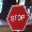

0
Steps per epoch: 768
Data Shapes
Train(24564, 32, 32, 3) (24564,)
Validation(6142, 32, 32, 3) (6142,)
data shape  (6, 2) <class 'pandas.core.frame.DataFrame'>


In [ ]:
from google.colab.patches import cv2_imshow
import math
############################### Split Data
X_train, X_validation, y_train, y_validation = train_test_split(images, classNo, test_size=testRatio)
# X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)
 
cv2_imshow(X_train[3])
print(y_train[3])
# X_train = ARRAY OF IMAGES TO TRAIN
# y_train = CORRESPONDING CLASS ID
total_images_train = X_train.shape[0]
total_images_test = X_validation.shape[0]
batch_size = 32
steps_per_epoch_train = math.ceil(total_images_train / batch_size)
print("Steps per epoch:",steps_per_epoch_train)
steps_per_epoch_test = math.ceil(total_images_test / batch_size)

############################### TO CHECK IF NUMBER OF IMAGES MATCHES TO NUMBER OF LABELS FOR EACH DATA SET
print("Data Shapes")
print("Train",end = "");print(X_train.shape,y_train.shape)
print("Validation",end = "");print(X_validation.shape,y_validation.shape)
#print("Test",end = "");print(X_validation.shape,y_validation.shape)
assert(X_train.shape[0]==y_train.shape[0]), "The number of images in not equal to the number of lables in training set"
assert(X_validation.shape[0]==y_validation.shape[0]), "The number of images in not equal to the number of lables in validation set"
#assert(X_test.shape[0]==y_test.shape[0]), "The number of images in not equal to the number of lables in test set"
assert(X_train.shape[1:]==(imageDimesions))," The dimesions of the Training images are wrong "
assert(X_validation.shape[1:]==(imageDimesions))," The dimesionas of the Validation images are wrong "
#assert(X_test.shape[1:]==(imageDimesions))," The dimesionas of the Test images are wrong"

In [ ]:
############################### PREPROCESSING THE IMAGES
def grayscale(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img
def equalize(img):
    img =cv2.equalizeHist(img)
    return img
def preprocessing(img):
    img = grayscale(img)     # CONVERT TO GRAYSCALE
    img = equalize(img)      # STANDARDIZE THE LIGHTING IN AN IMAGE
    img = img/255            # TO NORMALIZE VALUES BETWEEN 0 AND 1 INSTEAD OF 0 TO 255
    return img
    

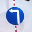

In [ ]:
cv2_imshow(X_train[random.randint(0,len(X_train)-1)]) # TO CHECK IF THE TRAINING IS DONE PROPERLY

X_train=np.array(list(map(preprocessing,X_train)))  # TO IRETATE AND PREPROCESS ALL IMAGES
X_validation=np.array(list(map(preprocessing,X_validation)))
#X_test=np.array(list(map(preprocessing,X_test)))


############################### ADD A DEPTH OF 1
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_validation=X_validation.reshape(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2],1)
#X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)

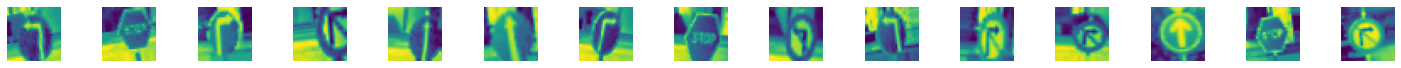

In [ ]:
############################### AUGMENTATAION OF IMAGES: TO MAKEIT MORE GENERIC
dataGen= ImageDataGenerator(featurewise_center=False,
                            featurewise_std_normalization=False,
                            width_shift_range=0.1,   # 0.1 = 10%     IF MORE THAN 1 E.G 10 THEN IT REFFERS TO NO. OF  PIXELS EG 10 PIXELS
                            height_shift_range=0.1,
                            zoom_range=0.2,  # 0.2 MEANS CAN GO FROM 0.8 TO 1.2
                            shear_range=0.1,  # MAGNITUDE OF SHEAR ANGLE
                            rotation_range=10)
                            # brightness_range=[0.8,1.2])  # DEGREES
dataGen.fit(X_train)
batches= dataGen.flow(X_train,y_train,batch_size=batch_size)  # REQUESTING DATA GENRATOR TO GENERATE IMAGES  BATCH SIZE = NO. OF IMAGES CREAED EACH TIME ITS CALLED
X_batch,y_batch = next(batches)
 
# TO SHOW AGMENTED IMAGE SAMPLES
fig,axs=plt.subplots(1,15,figsize=(20,5))
fig.tight_layout()
 
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(imageDimesions[0],imageDimesions[1]))
    axs[i].axis('off')
plt.show()
 
 
y_train = to_categorical(y_train,noOfClasses)
y_validation = to_categorical(y_validation,noOfClasses)
#y_test = to_categorical(y_test,noOfClasses)

In [ ]:
############################### CONVOLUTION NEURAL NETWORK MODEL
IMG_SIZE = 32
NUM_CLASSES = 6
def myModel():
    no_Of_Filters=32
    size_of_Filter=(5,5) # THIS IS THE KERNEL THAT MOVE AROUND THE IMAGE TO GET THE FEATURES.
                         # THIS WOULD REMOVE 2 PIXELS FROM EACH BORDER WHEN USING 32 32 IMAGE
    size_of_Filter2=(3,3)
    size_of_pool=(2,2)  # SCALE DOWN ALL FEATURE MAP TO GERNALIZE MORE, TO REDUCE OVERFITTING
    no_Of_Nodes = 1024   # NO. OF NODES IN HIDDEN LAYERS
    model= Sequential()
    model.add((Conv2D(32,size_of_Filter,input_shape=(imageDimesions[0],imageDimesions[1],1),activation='relu')))  # ADDING MORE CONVOLUTION LAYERS = LESS FEATURES BUT CAN CAUSE ACCURACY TO INCREASE
    model.add((Conv2D(no_Of_Filters, size_of_Filter, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool)) # DOES NOT EFFECT THE DEPTH/NO OF FILTERS
 
    model.add((Conv2D(no_Of_Filters //2, size_of_Filter2,activation='relu')))
    model.add((Conv2D(no_Of_Filters // 2, size_of_Filter2, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))
    #model.add(Dropout(0.5))
 
    model.add(Flatten())
    model.add(Dense(no_Of_Nodes,activation='relu'))
    #model.add(Dropout(0.5)) # INPUTS NODES TO DROP WITH EACH UPDATE 1 ALL 0 NONE
    model.add(Dense(noOfClasses,activation='softmax')) # OUTPUT LAYER
    # COMPILE MODEL
    model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    return model
def cnn_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=(32, 32, 1),
                     activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='softmax'))
    model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

    return model

############################### TRAIN
model = cnn_model()
print(model.summary())



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)        

In [ ]:
epochs = 1000

model_checkpoint = ModelCheckpoint(mode='auto', filepath='./Seg_Local-{epoch:03d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5', 
                      monitor='val_loss', 
                      save_best_only='True', 
                      save_weights_only='True', 
                      period=1,
                      verbose=1)
early_stopping = EarlyStopping(monitor='val_loss',
                                min_delta=0.0,
                                patience=10,
                                verbose=1)
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                          factor=0.2,
                                          patience=6,
                                          verbose=1,
                                          epsilon=0.001,
                                          cooldown=0,
                                          min_lr=0.00001)
callbacks = [model_checkpoint, early_stopping ,reduce_learning_rate]

print("Batch size",batch_size,"Steps per Epoch: ",steps_per_epoch_train)

history = model.fit_generator(dataGen.flow(X_train,y_train,batch_size=batch_size),steps_per_epoch=steps_per_epoch_train,epochs=epochs,validation_data=(X_validation,y_validation),shuffle=True,callbacks=callbacks)
 

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Batch size 32 Steps per Epoch:  768

Epoch 1/1000
768/768 [==============================] - 24s 32ms/step - loss: 0.3366 - accuracy: 0.8717 - val_loss: 0.0137 - val_accuracy: 0.9956

Epoch 00001: val_loss improved from inf to 0.01366, saving model to ./Seg_Local-001_loss-0.3363_val_loss-0.0137.h5
Epoch 2/1000
768/768 [==============================] - 19s 25ms/step - loss: 0.0454 - accuracy: 0.9860 - val_loss: 0.0064 - val_accuracy: 0.9985

Epoch 00002: val_loss improved from 0.01366 to 0.00642, saving model to ./Seg_Local-002_loss-0.0453_val_loss-0.0064.h5
Epoch 3/1000
768/768 [==============================] - 19s 25ms/step - loss: 0.0340 - accuracy: 0.9898 - val_loss: 0.0063 - val_accuracy: 0.9982

Epoch 00003: val_loss improved from 0.00642 to 0.00632, saving model to ./Seg_Local-003_loss-0.0338_val_loss-0.0063.h5
Epoch 4/1000
768/768 [==============================] - 19s 25ms/step - loss: 0.0247 - accuracy: 0.9931 - val_loss: 0.0046 - val_accuracy: 0.9985

Epoch 00004: val_loss 

SIGN:  Left 	Probability:  100.0 %


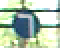

In [ ]:
def getCalssName(classNo):
    if   classNo == 0: return 'Stop'
    elif classNo == 1: return 'Right'
    elif classNo == 2: return 'Left'
    elif classNo == 3: return 'Straight'
    elif classNo == 4: return 'No Left'
    elif classNo == 5: return 'No Right'

model.load_weights('/content/Seg_Local-018_loss-0.0032_val_loss-0.0004.h5')
threshold=0.75
imgOrignal = cv2.imread('/content/Screen Shot 2020-05-22 at 19.07.26.png')
img = np.asarray(imgOrignal)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
#cv2_imshow(img)
img = img.reshape(1, 32, 32, 1)
#cv2.putText(imgOrignal, "CLASS: " , (20, 35), cv2.FONT_HERSHEY_SIMPLEX , 0.75, (0, 0, 255), 2, cv2.LINE_AA)
#cv2.putText(imgOrignal, "PROBABILITY: ", (20, 75), cv2.FONT_HERSHEY_SIMPLEX , 0.75, (0, 0, 255), 2, cv2.LINE_AA)
# PREDICT IMAGE
predictions = model.predict(img)
classIndex = model.predict_classes(img)
probabilityValue =np.amax(predictions)
print("SIGN: ",getCalssName(classIndex),"\tProbability: ", probabilityValue*100, "%")
# if probabilityValue > threshold:
#     cv2.putText(imgOrignal,str(classIndex)+" "+str(getCalssName(classIndex)), (120, 35), cv2.FONT_HERSHEY_SIMPLEX , 0.75, (0, 0, 255), 2, cv2.LINE_AA)
#     cv2.putText(imgOrignal, str(round(probabilityValue*100,2) )+"%", (180, 75), cv2.FONT_HERSHEY_SIMPLEX , 0.75, (0, 0, 255), 2, cv2.LINE_AA)
cv2_imshow(imgOrignal)

In [ ]:
from keras import backend as K
import tensorflow as tf
print(model.outputs)
print(model.inputs)
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        # Graph -> GraphDef ProtoBuf
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph


frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])
# Save to ./model/tf_model.pb
tf.train.write_graph(frozen_graph, "model", "goodgame_cnn_0506.pb", as_text=False)

[<tf.Tensor 'dense_2/Softmax:0' shape=(?, 6) dtype=float32>]
[<tf.Tensor 'conv2d_1_input:0' shape=(?, 32, 32, 1) dtype=float32>]
INFO:tensorflow:Froze 71 variables.
INFO:tensorflow:Converted 71 variables to const ops.


'model/goodgame_cnn_0506.pb'